In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import folium
from sklearn.cluster import KMeans
import requests
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
from scipy.spatial import cKDTree
from scipy.signal import convolve2d
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs

C:\Users\Robin\AppData\Local\Temp\ipykernel_257936\2410661594.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# Read HTML content from file
with open('./resources/station_ids.html', 'r', encoding='utf-8') as file:
    html = file.read()

# Parse HTML
soup = BeautifulSoup(html, 'html.parser')

# Find the table
table = soup.find('table')

# Extract table headers
headers = [header.text.strip() for header in table.find_all('th')][1:]

# print(headers)

# Extract table rows
data = []
for row in table.find_all('tr')[1:]:
    row_data = [cell.text.strip() for cell in row.find_all('td')]
    # print(row_data)
    if(row_data != []):
        data.append(row_data)

# Create DataFrame
df = pd.DataFrame(data, columns=headers)

# delete rows, where the string in column "Ende" doesnt include "2024"
df = df[~df['Ende'].str.contains('2024')]

# get just the first two columns (Stationsname and Stations_id)
df_important = df[['Stationsname', 'Stations_ID', 'Stations-kennung', 'Breite', 'Länge']]

# delete all duplicated rows
df_important.drop_duplicates(subset='Stationsname', keep='first', inplace=True)

In [3]:
# I want to reduce tha data to 500 rows. The data should be reduced by deleting rows where the Breite and Länge are closest to each other
# Assuming df is your DataFrame with columns ['Stationsname', 'Stations_ID', 'Breite', 'Länge']
# Convert Breite and Länge to radians for distance calculation

df_important['Breite'] = df_important['Breite'].astype(float)
df_important['Länge'] = df_important['Länge'].astype(float)

df_important['Breite_rad'] = df_important['Breite'] * (3.141592653589793 / 180)
df_important['Länge_rad'] = df_important['Länge'] * (3.141592653589793 / 180)

# Create input for KMeans clustering
X = df_important[['Breite_rad', 'Länge_rad']]

# Specify the number of clusters (desired number of rows after reduction)
num_clusters = 500

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_important['cluster'] = kmeans.fit_predict(X)

# Compute the centroid of each cluster
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Breite_rad', 'Länge_rad'])

# Find the nearest point in each cluster to its centroid
nearest_points = []
for cluster_label, centroid in centroids.iterrows():
    cluster_points = df_important[df_important['cluster'] == cluster_label]
    distances = ((cluster_points['Breite_rad'] - centroid['Breite_rad']) ** 2 + 
                 (cluster_points['Länge_rad'] - centroid['Länge_rad']) ** 2) ** 0.5
    nearest_point_idx = distances.idxmin()
    nearest_points.append(nearest_point_idx)

# Keep only the nearest points
reduced_df = df_important.loc[nearest_points]

# Drop the cluster column and radians columns
reduced_df.drop(['cluster', 'Breite_rad', 'Länge_rad'], axis=1, inplace=True)

# print(reduced_df)

In [4]:
url = 'https://dwd.api.proxy.bund.dev/v30/stationOverviewExtended'

headers_request = {
    'Accept': 'application/json'
}

# for each row get the Stations-kennung data
stations_kennung = df['Stations-kennung'].tolist()

stations_kennung = ','.join(stations_kennung)

# split it in parts of 500
stations_kennung = [stations_kennung[i:i + 500] for i in range(0, len(stations_kennung), 500)]

print(stations_kennung)

# # use the list to make an API request to get the data for each station
all_responses = {}
for stations in stations_kennung:
    params = {
        'stationIds': stations
    }
    response = requests.get(url, headers=headers_request, params=params)
    data = response.json()
    for station, content in data.items():
        # print(content) 
        all_responses[station] = content
    # print(data)


# print(last_precipitation_total)

['02783,70191,10771,02205,02205,02205,02205,10501,80310,02205,10501,02205,80313,19703,80316,8930,10503,8931,71501,76352,76351,91404,54336,44429,32135,73206,11207,90674,75115,11672,8373,7699,92564,13118,71151,8043,54365,92422,71524,10324,11646,73448,Q059,71645,10538,10778,93162,K242,85444,K242,9934,48437,54838,7979,8602,44530,13106,71575,43302,12953,9712,8922,10823,52437,11522,7892,90593,9713,8348,10594,8999,33102,9008,56145,8333,9231,20010,8125,7904,9010,31102,60224,8349,8560,8603,51505,7952,91414', ',10541,Q153,71639,Q153,73379,04013,9937,15019,54121,03874,03874,03874,48553,03874,03874,27036,7536,8633,12208,12636,30130,8350,8972,10087,10978,90632,10964,11486,90277,11827,10347,90667,11223,90370,04502,91440,70252,13160,92375,11133,9050,10797,9535,30361,7802,91171,11906,11100,10242,13612,42524,13309,02928,02928,Q751,71039,02928,Q751,02928,71038,02755,90129,02926,02926,02926,90128,02926,8814,04519,90722,71208,71523,7980,54668,13922,9982,9148,51159,11550,9315,51241,9479,10695,56007,54033,7

In [5]:
count = 0

for key, value in all_responses.items():
    if count < 10:
        print(key, value)
        count += 1
    else:
        break

10771 {'forecast1': {'stationId': '10771', 'start': 1708470000000, 'timeStep': 3600000, 'temperature': [60, 59, 56, 54, 52, 56, 55, 55, 51, 60, 69, 84, 97, 103, 109, 114, 112, 99, 90, 84, 73, 66, 63, 60, 58, 58, 57, 58, 59, 58, 58, 59, 61, 65, 69, 78, 85, 89, 95, 96, 96, 93, 89, 87, 85, 84, 83, 82, 82, 78, 75, 76, 68, 62, 56, 50, 49, 48, 52, 59, 65, 70, 74, 75, 73, 64, 53, 45, 38, 30, 23, 18, 13, 9, 7, 6, 5, 5, 3, 2, 5, 12, 25, 41, 53, 61, 69, 72, 67, 63, 55, 45, 35, 27, 20, 15, 10, 6, 3, 1, -3, -7, -7, -9, -4, 6, 20, 37, 52, 64, 69, 73, 72, 67, 59, 48, 41, 33, 28, 22, 19, 16, 13, 10, 6, 3, -2, -1, 2, 12, 24, 38, 49, 57, 62, 64, 63, 59, 54, 46, 38, 32, 26, 22, 18, 16, 14, 12, 10, 7, 4, 6, 9, 16, 28, 41, 55, 63, 66, 71, 70, 64, 54, 43, 40, 33, 28, 24, 20, 16, 13, 9, 8, 5, 4, 4, 6, 11, 23, 36, 47, 58, 64, 66, 65, 63, 56, 47, 39, 32, 27, 23, 19, 14, 10, 9, 4, 3, 1, 2, 7, 18, 31, 44, 60, 69, 76, 80, 80, 75, 68, 58, 49, 42, 37, 34, 30, 29, 22, 22, 18, 22, 17, 17, 21, 30, 44, 60, 70, 81, 87,

In [6]:
last_precipitation_total = {}
start_measurement = {}
for key, value in all_responses.items():

    # get index of current time:
    # get current time in ms since 1970
    current_time_ms = pd.Timestamp.now().timestamp() * 1000
    start_ms = value["forecast1"]["start"]
    timestep_ms = value["forecast1"]["timeStep"]
    # print(current_time_ms)
    # print(start_ms)

    # add timestep_ms to start_ms until it is bigger than current_time_ms and count the steps
    steps = 0
    while start_ms < current_time_ms:
        start_ms += timestep_ms
        steps += 1

    last_precipitation_total[key] = value["forecast1"]["precipitationTotal"][-1]
    # last_precipitation_total[key] = value["forecast1"]["precipitationTotal"][steps-1]
    # last_precipitation_total[key] = float(value["forecast1"]["temperature"][steps-1])/10
    # the value for start is in ms since 1970 so I convert it to a date
    # timestep = value["forecast1"]["timeStep"]
    # time_ms = value["forecast1"]["start"] + (timestep * len(value["forecast1"]["precipitationTotal"]))
    date = pd.to_datetime(start_ms-timestep_ms, unit='ms')
    start_measurement[key] = date

print(len(all_responses))
# print(all_responses)

580


In [7]:
# filter the df so that just the columns remain where Stations-kennung is in the list of keys of all_responses
filtered_df = df[df['Stations-kennung'].isin(all_responses.keys())]

# add the last_precipitation_total to the df
filtered_df['Last Precipitation Total'] = filtered_df['Stations-kennung'].map(last_precipitation_total)
filtered_df['Start Measurement'] = filtered_df['Stations-kennung'].map(start_measurement)

# just keep columns "Stationsname", "Stations_ID", "Stations-kennung", "Breite", "Länge", "Stations-höhe", "Last Precipitation Total"
filtered_df = filtered_df[['Stationsname', 'Stations_ID', 'Stations-kennung', 'Breite', 'Länge', 'Stations-höhe', 'Last Precipitation Total', 'Start Measurement']]

print(filtered_df)

                 Stationsname Stations_ID Stations-kennung   Breite   Länge  \
2                  Aach/Hegau       10771            10771    47.85    8.85   
7                      Aachen           3            10501  50.7827  6.0941   
10                     Aachen           3            10501  50.7827  6.0941   
66       Adelmannsfelden (Ph)       10324            10324    48.95      10   
193           Albstadt-Badkap          71             Q751   48.216   8.978   
...                       ...         ...              ...      ...     ...   
20514             Ziegelanger       11826            11826       50  10.617   
20517              Ziegenrück        5770            08021   50.613  11.647   
20554                  Zittau        5781            11210   50.885  14.811   
20593  Zweibrücken-Wattweiler       10314            10314   49.233   7.317   
20625                 Zwochau       12822            12822   51.467  12.267   

      Stations-höhe  Last Precipitation Total   Sta

In [8]:
# get max of column "Last Precipitation Total"
max_precipitation = filtered_df['Last Precipitation Total'].max()
print(max_precipitation)

33


In [9]:
# Create a map
# Create a map centered at a specific location
mymap = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for specific locations
locations = filtered_df[['Breite', 'Länge']].values

for loc in locations:
    folium.Marker(location=loc).add_to(mymap)

# Save the map to an HTML file
mymap.save("map_filtered.html")

In [10]:
# form the colums of filtered_df make a list of triples (Breite, Länge, Last Precipitation Total)
points = filtered_df[['Breite', 'Länge', 'Last Precipitation Total']].values.tolist()
# make all values float
points = [[float(y), float(x), float(z)] for x, y, z in points] # had to change x and y

In [116]:
# unique_colors = list(set([z for x,y,z in points]))
# print(unique_colors)

# Define the range of the coordinate system
x_range = np.arange(5, 16, 0.1)
y_range = np.arange(47, 56, 0.1)

# Initialize an array to store the closest point index for each coordinate
closest_point_index = np.zeros((len(x_range), len(y_range)), dtype=int)

# Calculate the closest point for each coordinate
for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        closest_dist = float('inf')
        for idx, (px, py, _) in enumerate(points):
            dist = distance.euclidean((x, y), (px, py))
            if dist < closest_dist:
                closest_dist = dist
                closest_point_index[i, j] = idx
        # print(f"closest_dist: {closest_dist}, closest_point_index: {closest_point_index[i, j]}")
        # print("end update")

# # Create a colormap based on the values of the closest points
# colors = [points[idx][2] for idx in closest_point_index.flatten()]

# # Plot the colored area
# plt.figure(figsize=(8, 6))
# plt.scatter(x_range.repeat(len(y_range)), np.tile(y_range, len(x_range)), c=colors, cmap='viridis')
# plt.colorbar(label='Precipitation (ml)')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Colored Area based on Closest Points')
# plt.show()

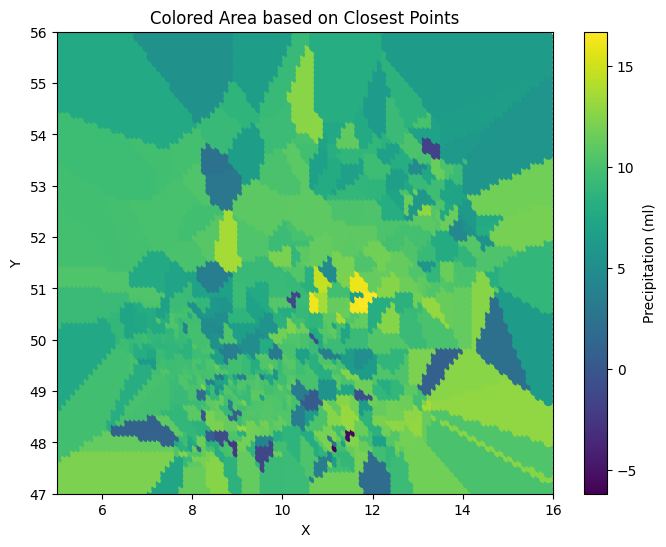

In [119]:
colors = [points[idx][2] for idx in closest_point_index.flatten()]

# Plot the colored area
plt.figure(figsize=(8, 6))
plt.scatter(x_range.repeat(len(y_range)), np.tile(y_range, len(x_range)), c=colors, cmap='viridis')

plt.xlim(5, 16)
plt.ylim(47, 56)

plt.colorbar(label='Precipitation (ml)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Colored Area based on Closest Points')
plt.show()

In [68]:
# # form the colums of filtered_df make a list of triples (Breite, Länge, Last Precipitation Total)
# points = filtered_df[['Breite', 'Länge', 'Last Precipitation Total']].values.tolist()
# # make all values float
# points = [[float(y), float(x), float(z)] for x, y, z in points] # had to change x and y

# print(len(points))

# Read the shape of Germany from the GeoPackage file
germany_shape = gpd.read_file("resources/gadm36_DEU_gpkg/gadm36_DEU.gpkg")

points_xy = [(x, y) for x, y, _ in points]

# x_min, x_max, y_min, y_max = germany_shape.total_bounds
# x_range = np.arange(x_min, x_max, 0.05)
# y_range = np.arange(y_min, y_max, 0.05)
x_range = np.arange(5, 16, 0.01)
y_range = np.arange(47, 56, 0.01)

xx, yy = np.meshgrid(x_range, y_range)
coordinates = np.column_stack((xx.ravel(), yy.ravel()))  # Flatten the grid coordinates

# # Create a spatial index for Germany
# germany_sindex = germany_shape.sindex

# within_germany = []
# for point in points:
#     point_geom = Point(point[:2])
#     possible_matches_index = list(germany_sindex.intersection(point_geom.bounds))
#     possible_matches = germany_shape.iloc[possible_matches_index]
#     precise_matches = possible_matches[possible_matches.intersects(point_geom)]
#     if not precise_matches.empty:
#         within_germany.append(point)

# # Extract the precipitation values corresponding to the points within Germany
# precipitation_values = [point[2] for point in within_germany]

# # Reshape the precipitation values to match the grid shape
# precipitation_grid = np.array(precipitation_values).reshape(xx.shape)

# Build a kd-tree from the sample points
tree = cKDTree(points_xy)

# Query the kd-tree for the nearest neighbor of each coordinate
distances, indices = tree.query(coordinates, k=1)

# Get the precipitation values corresponding to the nearest neighbors
precipitation_values = [points[idx][2] for idx in indices]

# Reshape the precipitation values to match the grid shape
precipitation_grid = np.array(precipitation_values).reshape(xx.shape)

In [14]:
# print(within_germany)

[(8.85, 47.85), (6.0941, 50.7827), (6.0941, 50.7827), (10.0, 48.95), (8.978, 48.216), (8.978, 48.216), (9.345, 50.745), (10.567, 50.3), (8.4671, 51.189), (10.443, 51.798), (10.443, 51.798), (10.443, 51.798), (10.443, 51.798), (10.443, 51.798), (10.5751, 49.2964), (10.5751, 49.2964), (13.267, 50.633), (13.017, 48.433), (13.4344, 54.6791), (13.4344, 54.6791), (13.4344, 54.6791), (12.9, 51.05), (8.167, 49.583), (8.367, 48.733), (7.6, 47.783), (8.469, 50.58), (8.25, 48.767), (8.273, 48.529), (8.273, 48.529), (8.273, 48.529), (8.273, 48.529), (8.273, 48.529), (8.733, 49.3), (9.661, 47.841), (7.417, 50.55), (9.567, 49.4), (12.9333, 53.7333), (7.417, 49.35), (8.058, 51.72), (8.058, 51.72), (11.45, 49.067), (10.5, 50.533), (7.5886, 50.4135), (7.5886, 50.4135), (8.628, 49.679), (11.433, 49.333), (14.15, 52.35), (13.406, 52.52), (13.406, 52.52), (13.301, 52.632), (13.731, 52.404), (13.731, 52.404), (13.731, 52.404), (13.731, 52.404), (13.731, 52.404), (13.731, 52.404), (13.304, 52.414), (13.56, 

In [147]:
# Apply a 5x5 averaging filter to smooth out the colors
# kernel = np.ones((25, 25)) / (25*25)  # Define a 5x5 averaging kernel
# smoothed_precipitation = convolve2d(precipitation_grid, kernel, mode='same', boundary='wrap')

In [12]:
# Create a GeoDataFrame containing the coordinates
coords_df = gpd.GeoDataFrame(geometry=gpd.points_from_xy(coordinates[:, 0], coordinates[:, 1]))

# Create a mask for the points within Germany
germany_mask = coords_df.geometry.within(germany_shape.unary_union)

# Reshape the mask to match the grid shape
germany_mask = germany_mask.values.reshape(xx.shape)

# Apply the mask to the smoothed precipitation grid
masked_precipitation = np.where(germany_mask, precipitation_grid, np.nan)

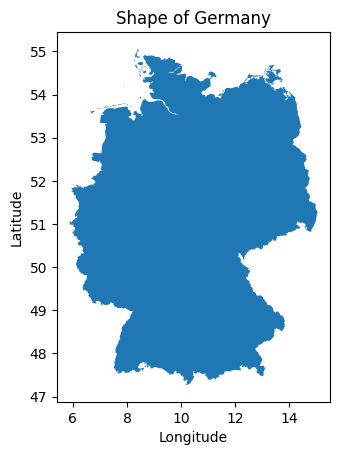

In [73]:
# read in shape of germany
# Path to the GeoPackage file containing the shape of Germany
gpkg_file = "resources/gadm36_DEU_gpkg/gadm36_DEU.gpkg"

# Read the GeoPackage file
germany_shape = gpd.read_file(gpkg_file)


# Plot the shape of Germany
germany_shape.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Shape of Germany')
plt.show()

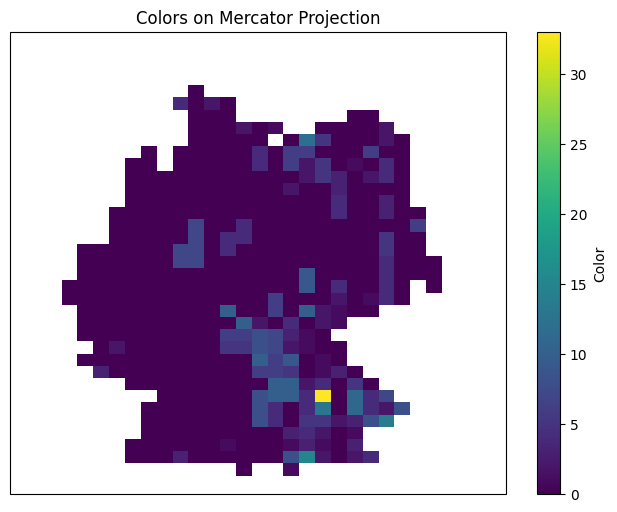

In [80]:
# fig, ax = plt.subplots(figsize=(8, 6))


# fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.Mercator()})
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.TransverseMercator(10)})
# Plot the colors on a grid
cax = ax.imshow(masked_precipitation, cmap='viridis', interpolation='nearest', aspect='auto', extent=(5, 16, 56, 47), transform=ccrs.PlateCarree())
# cax = ax.imshow(masked_precipitation, cmap='viridis', interpolation='nearest', aspect='auto', transform=ccrs.TransverseMercator(10))

# Add colorbar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Color')

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Colors on Mercator Projection')

ax.set_extent((5, 16, 47, 56), ccrs.PlateCarree())

# set the limits
# ax.set_xlim(0, 100)
# ax.set_ylim(47, 56)

# show the numbers on axes
# ax.set_xticks(np.arange(5, 16, 1))
# ax.set_yticks(np.arange(47, 56, 1))

# Show plot
plt.show()

# plt.figure(figsize=(10, 6))
# plt.pcolormesh(x_range, y_range, masked_precipitation, cmap='viridis', shading='auto')
# plt.colorbar(label='Precipitation (ml)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Colored Area based on Closest Points')
# # plt.axis('equal')
# plt.show()

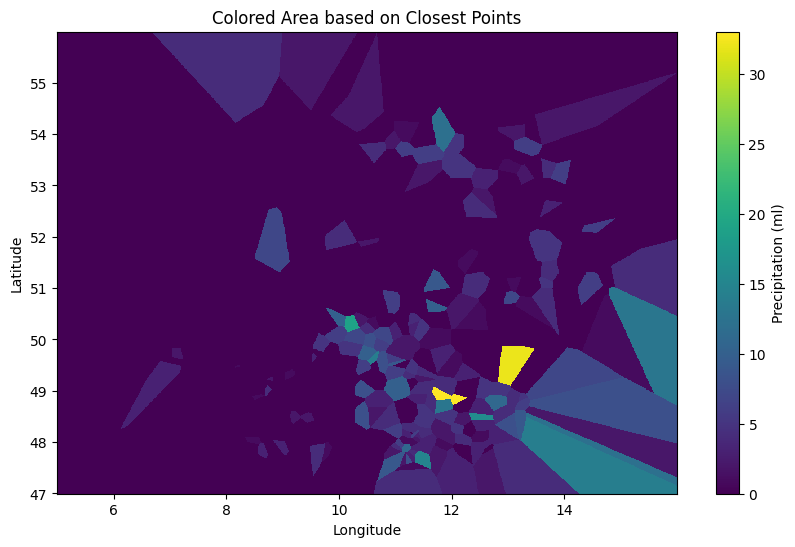

In [77]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(x_range, y_range, precipitation_grid, cmap='viridis', shading='auto')
plt.colorbar(label='Precipitation (ml)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Colored Area based on Closest Points')
# germany_shape.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
# plt.axis('equal')
plt.show()